# From AnnData to Pytorch lightning 

This tutorial introduces a custom datamodule, designed to be integrated into [pytorch lighning](https://lightning.ai/) model building pipelines. Under the hood, it build a pytorch dataset from an anndata object and sets up training, validation and test sets ready to interface with Lightning.

The tutorial is structured as follows:

[1. Example dataset](#load_data)

[2. Introducing the datamodule](#dm)

[3. Example 1 : simple neural network with pytorch lightning](#mlp)

[4. Example 2 : variational autoencoder with pytorch lightnig](#vae)

Notes:

* this tutorial is adapted from the original AnnLoader [tutorial](https://github.com/scverse/anndata-tutorials/blob/main/annloader.ipynb) by [Sergei Rybakov](https://github.com/koncopd)
* Checkout great alternative ways to building interfaces with pytorch, for instance, in [scvi-tools](https://scvi-tools.org/).
* Here, we use the [Pyro](http://pyro.ai) framework to simplify the code for a Variational Autoencoder.


## Load packages

In [1]:
import gdown
import os

import numpy as np
import scanpy as sc

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import LightningDataModule
from torch.utils.data import random_split
import torch.nn.functional as F
import pytorch_lightning as pl

# for scVI-style VAE
import pyro
import pyro.distributions as dist
from scvi.module.base import PyroBaseModuleClass
from pyro.nn import PyroModule
from typing import Any, Callable, Literal, Optional, Union
from inspect import signature

import scvi
scvi.settings.seed = 0

/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
Global seed set to 0


In [2]:
#from anndata_to_pytorch_dataloader.dataset import *
from anndata_to_pytorch_dataloader.dataset import * # causes error with cuda/nvidia packages

<a id='load_data'></a>

## Load data

The dataset used in this tutorial is the same as the original AnnLoader [tutorial](https://github.com/scverse/anndata-tutorials/blob/main/annloader.ipynb). It has 8 different cell types from 5 different technologies.

In [3]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'

if not os.path.exists(output):
    gdown.download(url, output, quiet=False)
    print(f"File '{output}' downloaded successfully.")
else:
    print(f"Found {output}.")

Found pancreas.h5ad.


In [4]:
adata = sc.read_h5ad("pancreas.h5ad")

In [5]:
# Convert back to raw counts 
adata.X = adata.raw.X # put raw counts to .X

In [6]:
adata.obs['size_factors'] = adata.X.sum(1)

In [7]:
adata.var = adata.var.reset_index()
adata.var.columns = ["gene_name"]

<a id='dm'></a>

## The datamodule

The AnnDataset class is designed to create a PyTorch dataset from an Anndata object, allowing seamless integration with PyTorch for deep learning tasks.

In PyTorch, a dataset is an abstraction that represents a collection of data samples. Specifically, a PyTorch dataset is a subclass of torch.utils.data.Dataset, and it provides an interface to access and manipulate individual data samples within a collection. It's designed to work seamlessly with PyTorch's data loading utilities, especially DataLoader, which efficiently handles batching, shuffling, and parallel data loading during model training. Essentially, this is helpful whenever you want to create batches of data and don't want to worry about handling the details!


This **dataset** can be used as input to a [PyTorch Lightning DataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). The Lightning DataModule is an organized and encapsulated unit that abstracts the data loading, processing, and preparation for machine learning or deep learning models. It acts as a bridge between the raw data and the model, providing a structured interface to manage and handle datasets within the PyTorch Lightning framework.


* Data Loading and Preparation: A DataModule handles the entire data pipeline, including loading datasets, splitting them into training, validation, and test sets, applying transformations, and preparing them for consumption by the model.

* Reproducibility and flexibility : the modular organization facilitates reproducibility (making it easier to track data transformations) and reusability (making it easier to swap datasets or use the same data setup across different models)

* Integration with PyTorch Lightning: DataModule seamlessly integrates with the PyTorch Lightning ecosystem, and can be fed directly into a PyTorch lightning trainer.

In [8]:
# The dataloader will convert our variables of interest into numpy arrays/tensors
# and will through an error if it receives string variables
# therefore we first encode our cell_type column into integers
# (will through an error if you pass any string variables)

ct_to_id_dict = {c : i for i, c in enumerate(adata.obs["cell_type"].unique())}
adata.obs["label"] = adata.obs["cell_type"].map(ct_to_id_dict)
                                             

`setup_simple_datamodule` return a PyTorch DataModule, that automatically sets up training/validation/test sets. For each batch, it returns a dictionary with an attribute `X` with adata.X if include_exprs = True, and any fields that were included in the setup_simple_datamodule arguments. For every value in obs_fields, it returns an item in the dataloader dictionary with a key of the format `obs_{column_name}` 

In [9]:
dm = setup_simple_datamodule(adata.copy(), 
                             train_frac=0.8,
                             val_frac = 0.1,
                             test_frac = 0.1, 
                             include_exprs=True, 
                             obs_fields=["label"],
                             batch_size = 32
                            )

/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
for d in dm.train_dataloader():
    print("X")
    print(d["X"].shape)
    print("Encoded cell type label")
    print(d["obs_label"].shape)
    break

X
torch.Size([32, 1000])
Encoded cell type label
torch.Size([32])


In [11]:
for d in dm.test_dataloader():
    print("X")
    print(d["X"].shape)
    print("Encoded cell type label")
    print(len(d["obs_label"]))
    print(d["obs_label"].shape)
    break

X
torch.Size([32, 1000])
Encoded cell type label
32
torch.Size([32])


<a id='mlp'></a>
## Model 1: Multi-layer perceptron for cell classification

As first example for how datamodules can work, we will build a simple neural network that takes gene expression data as input and outputs a probability for each cell type. This is an oversimplication, and mainly intended to provide a template for modules that can be replaced with more complex architectures.

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, out_dim):
        super().__init__()
        
        modules = []
        for in_size, out_size in zip([input_dim]+hidden_dims, hidden_dims):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.LayerNorm(out_size))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=0.05))
        modules.append(nn.Linear(hidden_dims[-1], out_dim))
        self.fc = nn.Sequential(*modules)
    
    def forward(self, *inputs):
        input_cat = torch.cat(inputs, dim=-1)
        return self.fc(input_cat)
    

In [13]:
class scLightning(pl.LightningModule):
    """
    Pytorch lightning implementation of basic cell type classifier
    
    Inputs:
    n_vars: 
        dimensions of input : this is the number of genes in slot X
        
    n_classes:
        number of classes for prediction output (eg cell type labels)
        
    label_name:
        name of the ground truth label that will be passed by the anndata module (here {obs/var}_{col_name})
    
    """

    def __init__(self, n_vars, n_classes, label_col):
        super().__init__()

        self.n_classes = n_classes
        
        self.model = MLP(input_dim = n_vars, 
                         hidden_dims = [128, 64, 32], 
                         out_dim = self.n_classes)
        

        for stage in ["train", "test", "val"]:
            setattr(self, f"{stage}_loss", [])
            setattr(self, f"{stage}_label_true", [])
            setattr(self, f"{stage}_label_pred", [])
            
        self.label_col = label_col
        

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
    def training_step(self, batch, batch_idx):
        x = batch["X"]
        y = batch[self.label_col].long()

        out = self(x)
        self.train_label_true.append(y)
        self.train_label_pred.append(out)

        loss = F.cross_entropy(out, y)

        self.train_loss.append(loss)
        self.log(f"train/loss", loss, prog_bar=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch["X"]
        y = batch[self.label_col].long()

        out = self(x)
        
        self.val_label_true.append(y)
        self.val_label_pred.append(out)

        loss = F.cross_entropy(out, y)

        self.val_loss.append(loss)
        self.log(f"val/loss", loss, prog_bar=True)

        return loss
    
    def test_step(self, batch, batch_idx):
        x = batch["X"]
        y = batch[self.label_col].long() 
        
        out = self(x)
        
        self.test_label_true.append(y)
        
        self.test_label_pred.append(out)

        loss = F.cross_entropy(out, y)

        self.test_loss.append(loss)
        self.log(f"test/loss", loss, prog_bar=True)

        return loss
    
    def on_train_epoch_end(self):
        self.end_epoch(stage = "train")

    def on_validation_epoch_end(self):
        self.end_epoch(stage = "val")

    def on_test_epoch_end(self):
        self.end_epoch(stage = "test")

    def end_epoch(self, stage):
        epoch_loss = getattr(self, f"{stage}_loss")
        epoch_loss = torch.stack(epoch_loss).sum()

        epoch_label_true = getattr(self, f"{stage}_label_true")
        epoch_label_true = torch.cat(epoch_label_true)

        epoch_label_pred = getattr(self, f"{stage}_label_pred")
        epoch_label_pred = torch.cat(epoch_label_pred)
        epoch_label_pred = torch.argmax(epoch_label_pred, dim=-1)

        # calculate accuracy 
        epoch_acc = (epoch_label_true == epoch_label_pred).float().mean()
        self.log(f"{stage}/acc", epoch_acc, prog_bar=True)

        # Reset 
        setattr(self, f"{stage}_loss", [])
        setattr(self, f"{stage}_label_true", [])
        setattr(self, f"{stage}_label_pred", [])

In [14]:
# we first initialize a class 
model = scLightning(n_vars = adata.n_vars, 
                    n_classes=adata.obs["cell_type"].nunique(), 
                    label_col = "obs_label")

In [15]:
# define a pytorch trainer
trainer = pl.Trainer(devices=1, max_epochs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [16]:
# lightning handles all of the training
trainer.fit(model, dm)


  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 139 K 
-------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.557     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 392/392 [00:13<00:00, 28.62it/s, v_num=7, train/loss=0.437, val/loss=0.211, val/acc=0.941]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 392/392 [00:13<00:00, 28.57it/s, v_num=7, train/loss=0.437, val/loss=0.211, val/acc=0.941]


In [17]:
# and testing
trainer.test(model, dm)

/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 50/50 [00:00<00:00, 345.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9247928857803345     │
│         test/loss         │    0.22907717525959015    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.22907717525959015, 'test/acc': 0.9247928857803345}]

<a id='vae'></a>

## Model 2: VAE implemtation in pytorch 

> note that this implementation has not been as thoroughly checked as scVI, and rather is intended to serve as an example of how we can use our datamodule for a more complicated models

In [18]:
# the scVI-style framework concatenates a one-hot-encoded vector representing the study/sample
# for this we create a new obs column with our encoded study
# and take care of one hot encoding inside the cVAE model
study_to_index = {s : i for i, s in enumerate(adata.obs["study"].unique().tolist())}

adata.obs["encoded_study"] = adata.obs["study"].map(study_to_index)

# we now define new datamodule that will pass the encoded_study and size_factors as well as labels 
dm_for_cvae = setup_simple_datamodule(adata.copy(), 
                                      train_frac=0.8, 
                                      include_exprs=True, 
                                      obs_fields=["label", "encoded_study", "size_factors"],
                                      batch_size = 32
                                     )

/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
#### Defining the cVAE model and custom trainer for interface with Pyro 
#### (the details here are not relevant to the datamodule class

class LowLevelPyroTrainingPlan(pl.LightningModule):
    """Lightning module task to train Pyro scvi-tools modules.
    from https://github.com/scverse/scvi-tools/blob/main/scvi/train/_trainingplans.py#L856
    rewrite TunableMixin as new class property so class behaves as lightning module

    Parameters
    ----------
    pyro_module
        An instance of :class:`~scvi.module.base.PyroBaseModuleClass`. This object
        should have callable `model` and `guide` attributes or methods.
    loss_fn
        A Pyro loss. Should be a subclass of :class:`~pyro.infer.ELBO`.
        If `None`, defaults to :class:`~pyro.infer.Trace_ELBO`.
    optim
        A Pytorch optimizer class, e.g., :class:`~torch.optim.Adam`. If `None`,
        defaults to :class:`torch.optim.Adam`.
    optim_kwargs
        Keyword arguments for optimiser. If `None`, defaults to `dict(lr=1e-3)`.
    n_steps_kl_warmup
        Number of training steps (minibatches) to scale weight on KL divergences from 0 to 1.
        Only activated when `n_epochs_kl_warmup` is set to None.
    n_epochs_kl_warmup
        Number of epochs to scale weight on KL divergences from 0 to 1.
        Overrides `n_steps_kl_warmup` when both are not `None`.
    scale_elbo
        Scale ELBO using :class:`~pyro.poutine.scale`. Potentially useful for avoiding
        numerical inaccuracy when working with very large ELBO.
    """

    def __init__(
        self,
        pyro_module: PyroBaseModuleClass,
        loss_fn: Optional[pyro.infer.ELBO] = None,
        optim: Optional[torch.optim.Adam] = None,
        optim_kwargs: Optional[dict] = None,
        n_steps_kl_warmup: Union[int, None] = None,
        n_epochs_kl_warmup: Union[int, None] = 400,
        scale_elbo: float = 1.0,
    ):
        super().__init__()
        self.module = pyro_module
        self._n_obs_training = None

        optim_kwargs = optim_kwargs if isinstance(optim_kwargs, dict) else {}
        if "lr" not in optim_kwargs.keys():
            optim_kwargs.update({"lr": 1e-3})
        self.optim_kwargs = optim_kwargs

        self.loss_fn = pyro.infer.Trace_ELBO() if loss_fn is None else loss_fn
        self.optim = torch.optim.Adam if optim is None else optim
        self.n_steps_kl_warmup = n_steps_kl_warmup
        self.n_epochs_kl_warmup = n_epochs_kl_warmup
        self.use_kl_weight = False
        if isinstance(self.module.model, PyroModule):
            self.use_kl_weight = (
                "kl_weight" in signature(self.module.model.forward).parameters
            )
        elif callable(self.module.model):
            self.use_kl_weight = "kl_weight" in signature(self.module.model).parameters
        self.scale_elbo = scale_elbo
        self.scale_fn = (
            lambda obj: pyro.poutine.scale(obj, self.scale_elbo)
            if self.scale_elbo != 1
            else obj
        )
        self.differentiable_loss_fn = self.loss_fn.differentiable_loss
        self.training_step_outputs = []

    def training_step(self, batch, batch_idx):
        """Training step for Pyro training."""
        args, kwargs = self.module._get_fn_args_from_batch(batch)
        # Set KL weight if necessary.
        # Note: if applied, ELBO loss in progress bar is the effective KL annealed loss, not the true ELBO.
        if self.use_kl_weight:
            kwargs.update({"kl_weight": self.kl_weight})
        # pytorch lightning requires a Tensor object for loss
        loss = self.differentiable_loss_fn(
            self.scale_fn(self.module.model),
            self.scale_fn(self.module.guide),
            *args,
            **kwargs,
        )
        out_dict = {"loss": loss}
        self.training_step_outputs.append(out_dict)
        return out_dict

    def on_train_epoch_end(self):
        """Training epoch end for Pyro training."""
        outputs = self.training_step_outputs
        elbo = 0
        n = 0
        for out in outputs:
            elbo += out["loss"]
            n += 1
        elbo /= n
        self.log("elbo_train", elbo, prog_bar=True)
        self.training_step_outputs.clear()

    def configure_optimizers(self):
        """Configure optimizers for the model."""
        return self.optim(self.module.parameters(), **self.optim_kwargs)

    def forward(self, *args, **kwargs):
        """Passthrough to the model's forward method."""
        return self.module(*args, **kwargs)

    @property
    def kl_weight(self):
        """Scaling factor on KL divergence during training."""
        return _compute_kl_weight(
            self.current_epoch,
            self.global_step,
            self.n_epochs_kl_warmup,
            self.n_steps_kl_warmup,
            min_kl_weight=1e-3,
        )

    @property
    def n_obs_training(self):
        """Number of training examples.

        If not `None`, updates the `n_obs` attr
        of the Pyro module's `model` and `guide`, if they exist.
        """
        return self._n_obs_training

    @n_obs_training.setter
    def n_obs_training(self, n_obs: int):
        # important for scaling log prob in Pyro plates
        if n_obs is not None:
            if hasattr(self.module.model, "n_obs"):
                self.module.model.n_obs = n_obs
            if hasattr(self.module.guide, "n_obs"):
                self.module.guide.n_obs = n_obs

        self._n_obs_training = n_obs

    @property
    def _tunables(cls): #-> list[Any]:
        """Returns the tunable attributes of the model class."""
        _tunables = []
        for attr_key in dir(cls):
            if attr_key == "_tunables":
                # Don't recurse
                continue
            attr = getattr(cls, attr_key)
            if hasattr(attr, "_tunables") or isfunction(attr):
                _tunables.append(attr)
        return _tunables

class cVAE(nn.Module):
    # The code is based on the scarches trVAE model
    # https://github.com/theislab/scarches/blob/v0.3.5/scarches/models/trvae/trvae.py
    # and on the pyro.ai Variational Autoencoders tutorial
    # http://pyro.ai/examples/vae.html
    # adapted from https://github.com/scverse/anndata-tutorials/blob/main/annloader.ipynb
    def __init__(self, input_dim, n_conds, n_classes, hidden_dims, latent_dim, study_to_index):
        super().__init__()
        
        self.encoder = MLP(input_dim+n_conds, hidden_dims, 2*latent_dim) # output - mean and logvar of z
        
        self.decoder = MLP(latent_dim+n_conds, hidden_dims[::-1], input_dim)
        self.theta = nn.Linear(n_conds, input_dim, bias=False)
        
        self.classifier = nn.Linear(latent_dim, n_classes)
        
        self.latent_dim = latent_dim
        
        self.study_to_index = study_to_index
    
    def model(self, x, batches, classes, size_factors):
        pyro.module("cvae", self)
        
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc = x.new_zeros((batch_size, self.latent_dim))
            z_scale = x.new_ones((batch_size, self.latent_dim))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            classes_probs = self.classifier(z).softmax(dim=-1)
            pyro.sample("class", dist.Categorical(probs=classes_probs), obs=classes)
            
            dec_mu = self.decoder(z, batches).softmax(dim=-1) * size_factors[:, None]
            dec_theta = torch.exp(self.theta(batches))
            
            logits = (dec_mu + 1e-6).log() - (dec_theta + 1e-6).log()
            
            pyro.sample("obs", dist.NegativeBinomial(total_count=dec_theta, logits=logits).to_event(1), obs=x.int())
    
    def guide(self, x, batches, classes, size_factors):
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc_scale = self.encoder(x, batches)
            
            z_mu = z_loc_scale[:, :self.latent_dim]
            z_var = torch.sqrt(torch.exp(z_loc_scale[:, self.latent_dim:]) + 1e-4)
            
            pyro.sample("latent", dist.Normal(z_mu, z_var).to_event(1))

    def _get_fn_args_from_batch(self, batch):
            #tensor_dict: dict[str, torch.Tensor]) -> Iterable | dict:
            #usgae: args, kwargs = self.module._get_fn_args_from_batch(batch)
        """Parse the minibatched data to get the correct inputs for ``model`` and ``guide``.

        In Pyro, ``model`` and ``guide`` must have the same signature. This is a helper method
        that gets the args and kwargs for these two methods. This helper method aids ``forward`` and
        ``guide`` in having transparent signatures, as well as allows use of our generic
        :class:`~scvi.dataloaders.AnnDataLoader`.

        Returns
        -------
        args and kwargs for the functions, args should be an Iterable and kwargs a dictionary.
        """

        # split into x, batches, classes, size_factors
        
        # do the one hot encoding here 
        sample = torch.stack([self.one_hot_encode_study(batch["obs_encoded_study"][i]) for i in range(len(batch["obs_encoded_study"]))], 
                             dim = 0).to(torch.float32).to(batch["X"].device)
        
        
        return [batch["X"], sample, batch["obs_label"], batch["obs_size_factors"]], {}
    
    def one_hot_encode_study(self, study_index):
        study_index_int = int(study_index.item()) 
        num_classes = len(study_to_index)
        return F.one_hot(torch.tensor(study_index_int), num_classes=num_classes)
    
def _compute_kl_weight(
    epoch: int,
    step: int,
    n_epochs_kl_warmup: Optional[int],
    n_steps_kl_warmup: Optional[int],
    max_kl_weight: float = 1.0,
    min_kl_weight: float = 0.0,
) -> float:
    """Computes the kl weight for the current step or epoch.
    from https://github.com/scverse/scvi-tools/blob/main/scvi/train/_trainingplans.py#L856

    If both `n_epochs_kl_warmup` and `n_steps_kl_warmup` are None `max_kl_weight` is returned.

    Parameters
    ----------
    epoch
        Current epoch.
    step
        Current step.
    n_epochs_kl_warmup
        Number of training epochs to scale weight on KL divergences from
        `min_kl_weight` to `max_kl_weight`
    n_steps_kl_warmup
        Number of training steps (minibatches) to scale weight on KL divergences from
        `min_kl_weight` to `max_kl_weight`
    max_kl_weight
        Maximum scaling factor on KL divergence during training.
    min_kl_weight
        Minimum scaling factor on KL divergence during training.
    """
    if min_kl_weight > max_kl_weight:
        raise ValueError(
            f"min_kl_weight={min_kl_weight} is larger than max_kl_weight={max_kl_weight}."
        )

    slope = max_kl_weight - min_kl_weight
    if n_epochs_kl_warmup:
        if epoch < n_epochs_kl_warmup:
            return slope * (epoch / n_epochs_kl_warmup) + min_kl_weight
    elif n_steps_kl_warmup:
        if step < n_steps_kl_warmup:
            return slope * (step / n_steps_kl_warmup) + min_kl_weight
    return max_kl_weight

In [20]:
model = cVAE(input_dim=adata.n_vars, 
             n_conds=adata.obs["study"].nunique(), 
             n_classes=adata.obs["cell_type"].nunique(), 
             hidden_dims=[128, 64, 32], 
             latent_dim=10, 
             study_to_index = study_to_index
            )

In [21]:
pyro_model = LowLevelPyroTrainingPlan(model)

In [22]:
trainer = pl.Trainer(devices=1, max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(pyro_model, dm_for_cvae)

/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name   | Type | Params
--------------------------------
0 | module | cVAE | 285 K 
--------------------------------
285 K     Trainable params
0         Non-trainable params
285 K     Total params
1.143     Total estimated model params size (MB)
/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 9: 100%|██████████| 392/392 [00:11<00:00, 35.25it/s, v_num=8, elbo_train=2.42e+4]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 392/392 [00:11<00:00, 35.11it/s, v_num=8, elbo_train=2.42e+4]


In [24]:
def get_latent_representation(model, dm, study_to_index):
    """
    Extracts the latent representation from the trained cVAE from the given model using data from DataModule (dm).

    Args:
    - model (cVAE): The model from which the latent representation means are extracted.
    - dm : a data module of class SimpleDataModule(LightningDataModule)
    - study_to_index (dict): A dictionary mapping study names to corresponding indices.

    Returns:
    - numpy.ndarray: An array containing the mean values of the latent variables for each sample.
    """

    def one_hot_encode_study(study_index):
        study_index_int = int(study_index.item())
        num_classes = len(study_to_index)
        return F.one_hot(torch.tensor(study_index_int), num_classes=num_classes)


    full_data = torch.stack([d["X"] for d in dm.train_data] + [d["X"] for d in dm.val_data] + [d["X"] for d in dm.test_data])
    studies = [d["obs_encoded_study"] for d in dm.train_data] + [d["obs_encoded_study"] for d in dm.val_data] + [d["obs_encoded_study"] for d in dm.test_data]
    studyx = torch.stack([one_hot_encode_study(s) for s in studies], dim = 0).to(torch.float32)

    means = model.encoder(torch.tensor(full_data, dtype = torch.float32),
                          studyx)[:, :10] # get mean values of the latent variables

    return means.data.cpu().numpy()


/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_20379/2007378203.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means = model.encoder(torch.tensor(full_data, dtype = torch.float32),
/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adr/miniconda3/envs/scvi_hack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/adr/miniconda3/envs/scvi

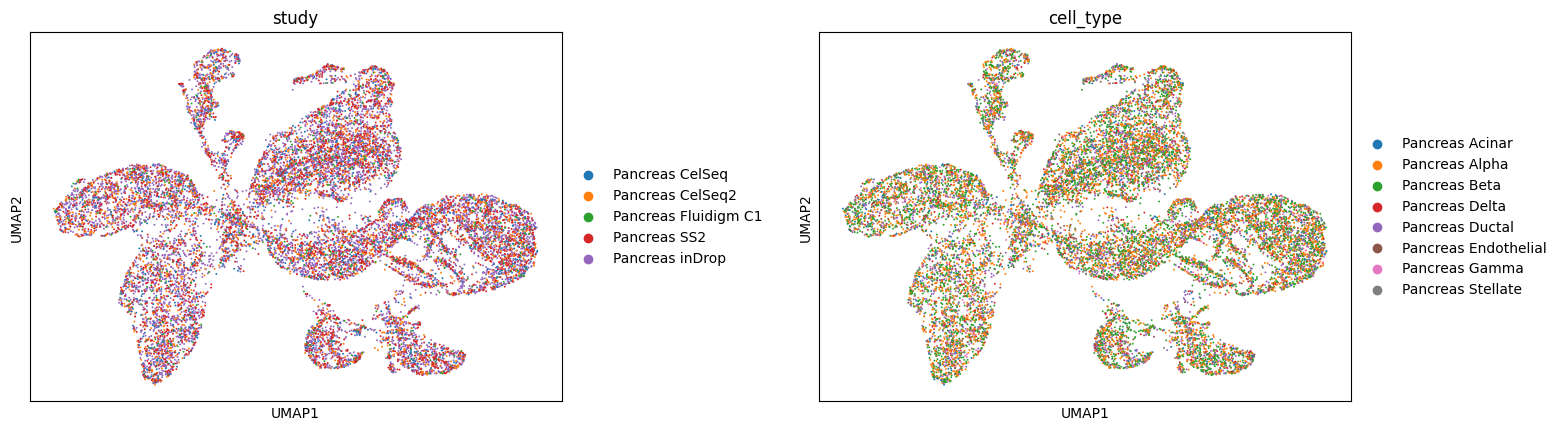

In [25]:
adata.obsm['X_cvae'] = get_latent_representation(model, dm_for_cvae, study_to_index)

sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)

sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)